<a href="https://colab.research.google.com/github/CesarRodriguez19/EstadisticaVerano/blob/main/U_3_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
pip install alpha_vantage


In [17]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Entra a https://www.alphavantage.co/support/#api-key
# Registrate para obtener tu api-key

# Tu clave de API (reemplaza esta por la tuya)
my_key = '0AE9Z02GA7PEC4W2'   # esta es mía, no la uses o habrá problemas

# Crear objeto TimeSeries
ts = TimeSeries(key=my_key, output_format='pandas')

# Obtener datos diarios de AMZN
# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener
ticker = 'TSLA'
data, meta = ts.get_daily(symbol=ticker, outputsize='full')

columnas = [ticker + '_' + i for i in ['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = columnas

# YYYY-mm-dd
inicio = '2022-01-20'
fin = '2025-01-20'
df = data[(data.index >= inicio) & (data.index <= fin)]

df

,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Volume
date,,,,,
2025-01-17,421.50,439.7400,419.750,426.50,94991429.0
2025-01-16,423.49,424.0000,409.130,413.82,68335151.0
2025-01-15,409.90,429.8000,405.661,428.22,81375460.0
2025-01-14,414.34,422.6400,394.540,396.36,84565022.0
2025-01-13,383.21,403.7900,380.070,403.31,67580494.0
...,...,...,...,...,...
2022-01-26,952.43,987.6900,906.000,937.41,34955761.0
2022-01-25,914.20,951.2600,903.210,918.40,28865302.0
2022-01-24,904.76,933.5131,851.470,930.00,50791714.0


##Medias móviles

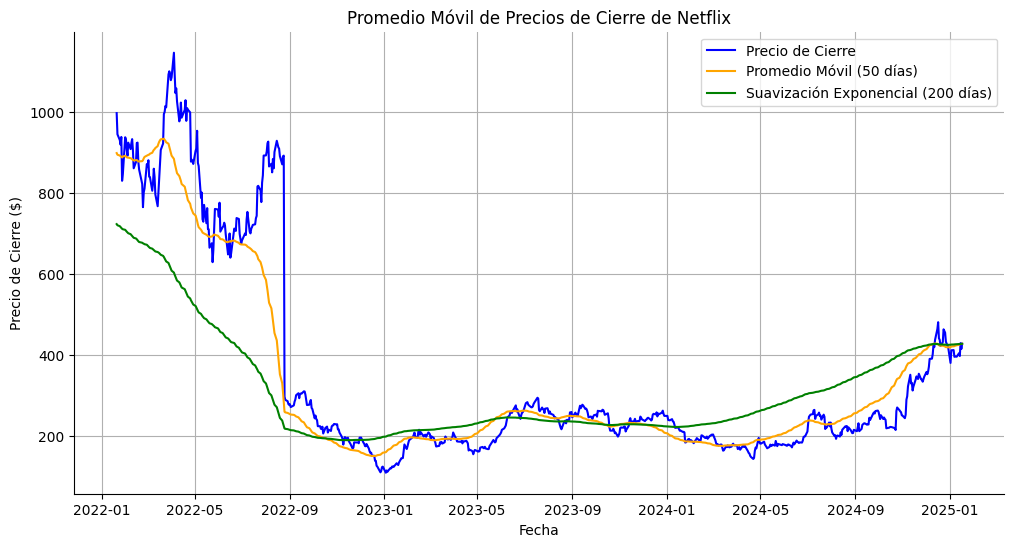

In [18]:
# Promedio Móvil Simple
ventana_sma = 50
df['SMA'] = df['TSLA_Close'].ewm(span=ventana_sma, adjust=False).mean()

# Promedio Móvil Exponencial
ventana_ses = 200
df['SES'] = df['TSLA_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['TSLA_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de Netflix')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

##Prueba Dickey-Fuller Aumentada


In [20]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['TSLA_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -0.44809084290247736
p-value: 0.9017544144927021
La tendencia no es estacionaria (aceptamos la hipótesis nula).


##Regresión polinomial


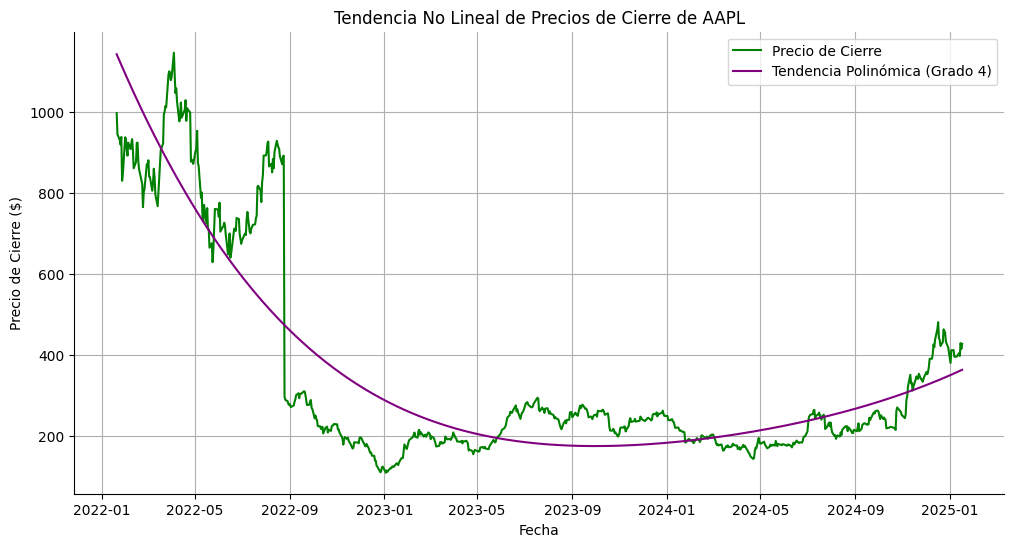

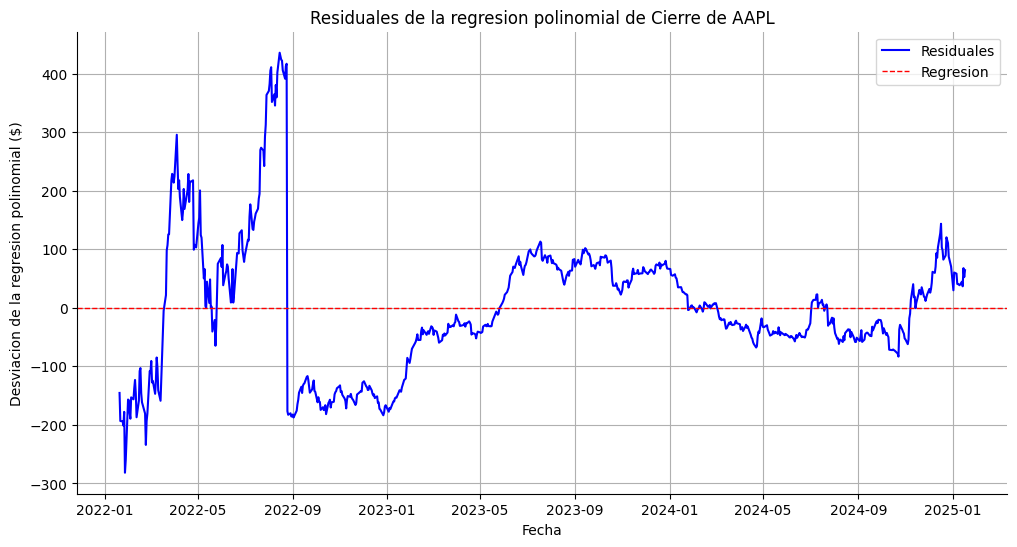

In [21]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['TSLA_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 4
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

##Para Pros: Series de Fourier

In [22]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Frecuencias principales:
    frecuencia      magnitud  longitud_de_onda
0    0.002660  31168.399987        376.000000
1    0.003989  20992.841920        250.666667
2    0.013298  19869.764290         75.200000
3    0.011968  18468.657548         83.555556
4    0.005319  17031.177393        188.000000


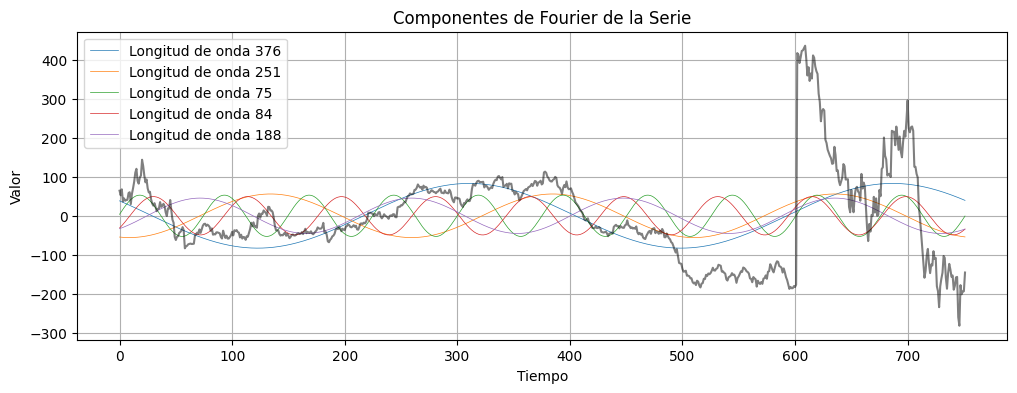

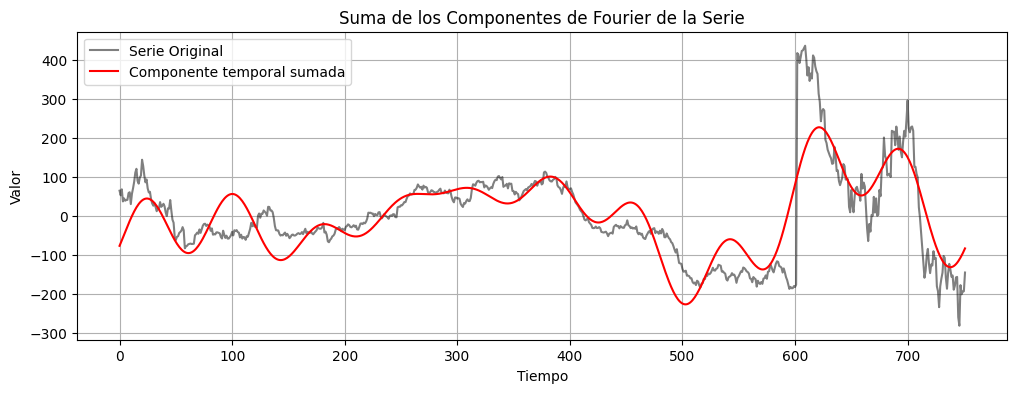

In [23]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico)

# cts: componente temporal sumado

##Descomposición de la serie

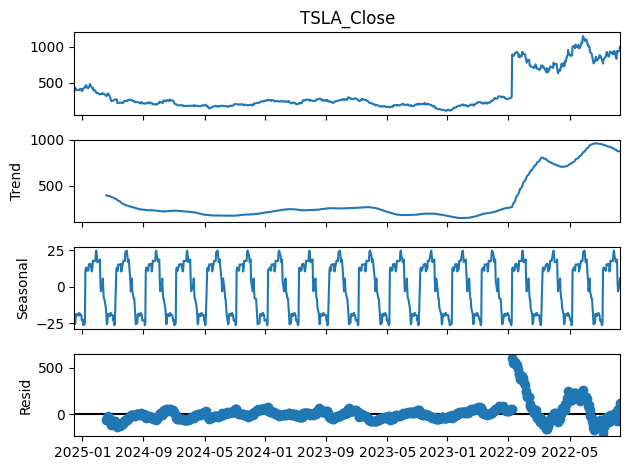

In [24]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['TSLA_Close'],
    model='additive',
    period=42,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

In [25]:

#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(descomposicion.resid.dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -4.530512241099454
p-value: 0.00017312844208854298
La tendencia es estacionaria (rechazamos la hipótesis nula).


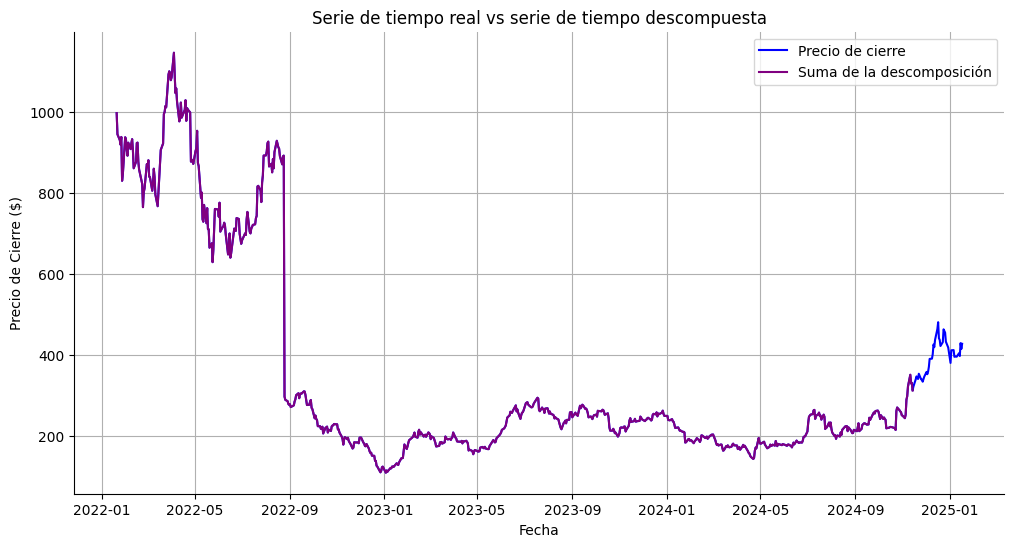

In [27]:

# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['TSLA_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

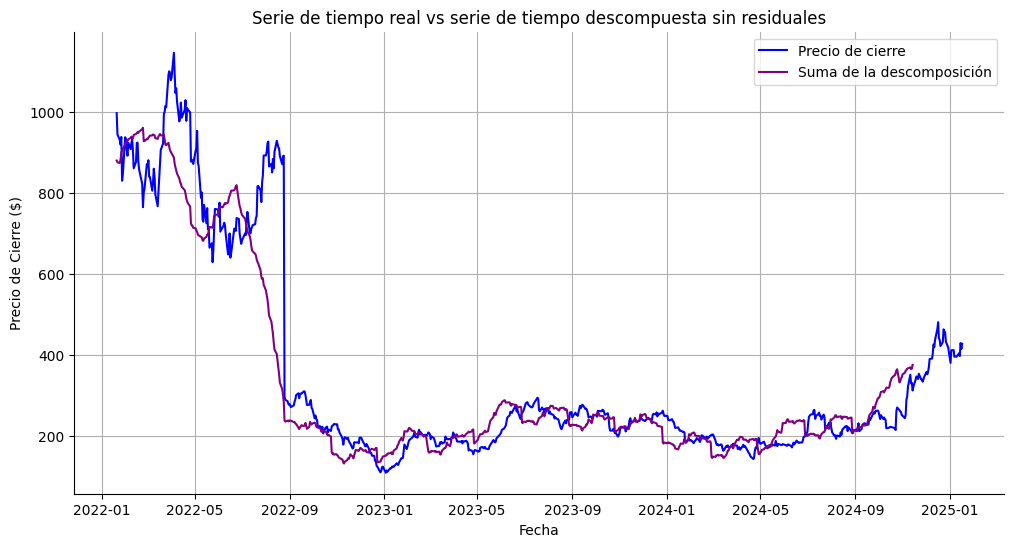

In [28]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['TSLA_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


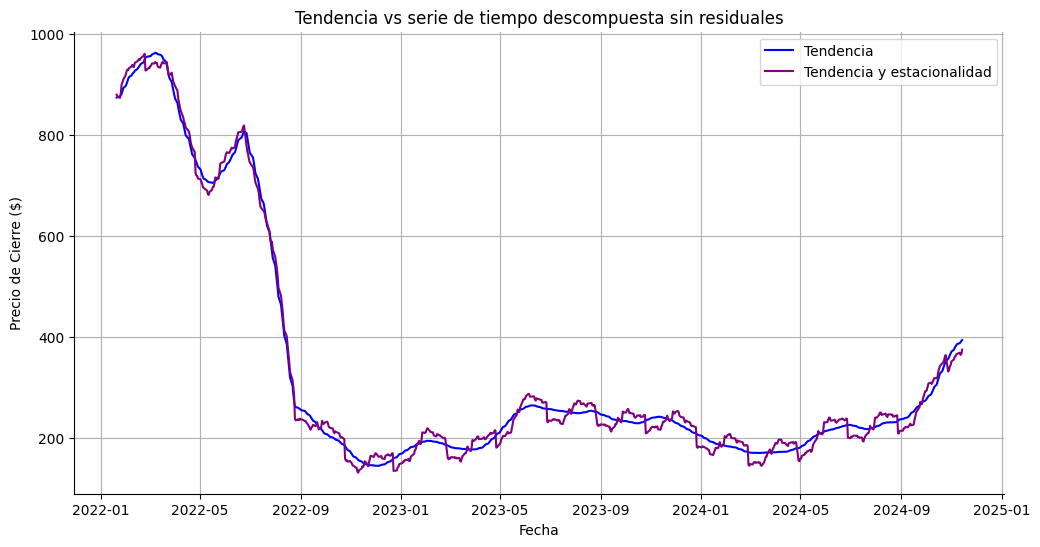

In [29]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(descomposicion.trend, label='Tendencia', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Tendencia y estacionalidad', color='purple')
plt.title('Tendencia vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


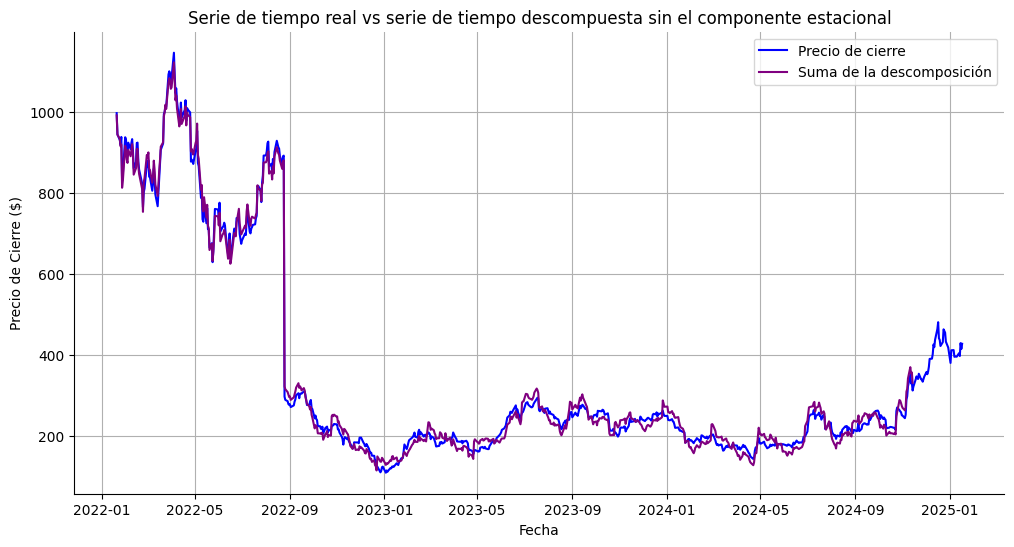

In [31]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['TSLA_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin el componente estacional')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()